# Аналіз служби обслуговування маркетплейсу
## Опис кейсу

У складі маркетплейсу 2 сервіси:
* платформа для роздрібного продажу
* платформа для гуртового продажу

Після численних скарг про низьку якість роботи відділу підтримки, потрбіно проаналізувати, як можна покращити рівень обслуговування клієнтів.

<b>Вхідні дані:</b>
- кожен продукт має свою команду підтримки
- кожний запит агент служби підтримки повинен виконати до 5 хв з моменту взяття в роботу
- за очікуванням менеджменту, в рамках кожного дня час від виникнення нового запиту користувача до його закриття повинний складати 15 хв. Поганим вважається, якщо користувач сервісу чекає на відповідь більше 45 хв

<b>Опис даних:</b>

<u>Таблиця df</u> - дані про кожний запит до модерації. Містять в собі інформацію про сам запит та модератора, який його виконував.
- id_request - унікальний ідентифікатор запиту;
- moderator - унікальний ідентифікатор агента підтримки;
- team - параметр команди (retail / wholesale);
- request_time - час отримання запиту;
- start_time - час початку обробки кейсу;
- finish_time - час кінця обробки кейсу.


<b>Завдання:</b>
- проаналізувати відповідність роботи служби підтримки очікуванням менеджменту
- визначити причини виникнення затримки служби підтримки
- запропонувати шляхи вирішення затримки

In [54]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")
url = 'test_case_moderators.csv'

## Проаналізуємо відповідність роботи служби підтримки очікуванням менеджменту
Оглянемо датасет, спробуємо додати тимчасові метрики та витягти дані, що можуть допогти в аналізі поточної роботи служби підтримки.

In [55]:
df = pd.read_csv(url)
df.iloc[:, [2, 3, 4]] = df.iloc[:, [2, 3, 4]].apply(pd.to_datetime, axis=0)
df

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail
...,...,...,...,...,...,...
35612,117,222193,2020-12-31 21:55:12,2020-12-31 22:06:36,2020-12-31 22:08:23,retail
35613,117,222210,2020-12-31 22:03:21,2020-12-31 22:08:24,2020-12-31 22:10:20,retail
35614,117,222211,2020-12-31 22:03:45,2020-12-31 22:12:08,2020-12-31 22:12:10,retail
35615,117,222213,2020-12-31 22:05:19,2020-12-31 22:12:10,2020-12-31 22:12:12,retail


In [56]:
df['processing_time'] = (df['finish_time'] - df['start_time']).dt.total_seconds()
df['delay'] = (df['finish_time'] - df['request_time']).dt.total_seconds()
df

,moderator,id_request,request_time,start_time,finish_time,team,processing_time,delay
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail,91.0,637246.0
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail,1.0,571768.0
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale,280.0,636223.0
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail,144.0,596481.0
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail,624.0,143509.0
...,...,...,...,...,...,...,...,...
35612,117,222193,2020-12-31 21:55:12,2020-12-31 22:06:36,2020-12-31 22:08:23,retail,107.0,791.0
35613,117,222210,2020-12-31 22:03:21,2020-12-31 22:08:24,2020-12-31 22:10:20,retail,116.0,419.0
35614,117,222211,2020-12-31 22:03:45,2020-12-31 22:12:08,2020-12-31 22:12:10,retail,2.0,505.0
35615,117,222213,2020-12-31 22:05:19,2020-12-31 22:12:10,2020-12-31 22:12:12,retail,2.0,413.0


,mean_processing_time,prct_success_processing,mean_delay,prct_success_delay,prct_satisfactorily_delay,prct_successful_proc_moderators,prct_successful_delay_moderators,prct_satisfactorily_delay_moderators,successuful_moderators
retail,0 days 00:01:58.634652406,0.923565,0 days 10:09:45.821033868,0.149947,0.450410,0.916667,0.125,0.125,"[110, 134, 138]"
wholesale,0 days 00:02:24.939560948,0.873564,2 days 13:19:54.618423490,0.020934,0.049463,1.000000,0.080,0.080,"[129, 171]"


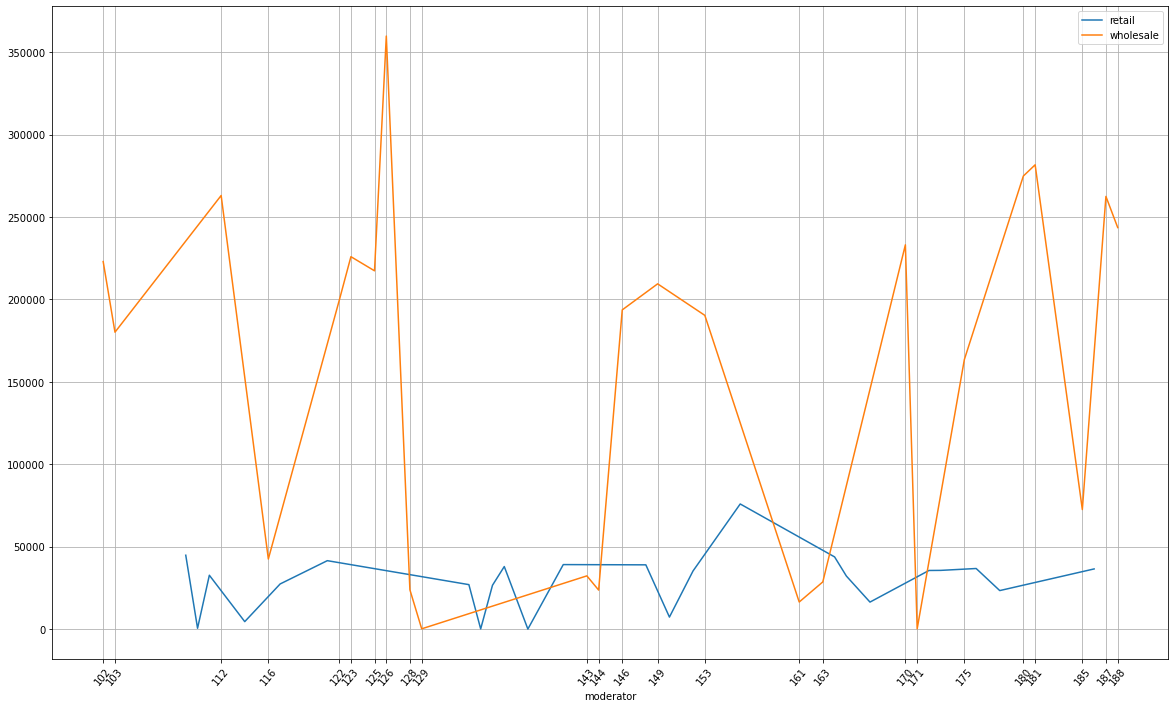

In [57]:
grouped_team = df.groupby('team')

mean_proc_delay = grouped_team[['processing_time', 'delay']].mean().applymap(pd.Timedelta, unit='s')
mean_proc_delay.rename(columns={'processing_time': 'mean_processing_time', 'delay': 'mean_delay'}, inplace=True)

prct_success_processing = df[df['processing_time'] <= 5*60].groupby('team').count().iloc[:,0] / grouped_team.count().iloc[:, 0]
prct_success_processing.name = 'prct_success_processing'

prct_success_delay = df[df['delay'] <= 15*60].groupby('team').count().iloc[:,0] / grouped_team.count().iloc[:, 0]
prct_success_delay.name = 'prct_success_delay'
prct_satisfactorily_delay = df[df['delay'] <= 45*60].groupby('team').count().iloc[:,0] / grouped_team.count().iloc[:, 0]
prct_satisfactorily_delay.name = 'prct_satisfactorily_delay'

grouped_team_moderator = df.groupby(['team', 'moderator']).mean()
well_moderators = grouped_team_moderator[grouped_team_moderator['processing_time'] < 5*60]
prct_successful_proc_moderators = (well_moderators.count(level=0) / grouped_team_moderator.count(level=0)).iloc[:, 0]
prct_successful_proc_moderators.name = 'prct_successful_proc_moderators'

successful_moderators = grouped_team_moderator[(grouped_team_moderator['delay'] <= 15*60) & (grouped_team_moderator['processing_time'] <= 5*60)]
satisfactorily_moderators = grouped_team_moderator[(grouped_team_moderator['delay'] <= 45*60) & (grouped_team_moderator['processing_time'] <= 5*60)]
prct_successful_moderators = (successful_moderators.count(level=0) / grouped_team_moderator.count(level=0)).iloc[:, 0]
prct_successful_moderators.name = 'prct_successful_delay_moderators'
prct_satisfactorily_moderators = (satisfactorily_moderators.count(level=0) / grouped_team_moderator.count(level=0)).iloc[:, 0]
prct_satisfactorily_moderators.name = 'prct_satisfactorily_delay_moderators'

grouped_team_moderator.loc['retail','delay'].plot(label='retail', legend=True, xticks=grouped_team_moderator.loc['retail'].index, rot=50)
grouped_team_moderator.loc['wholesale', 'delay'].plot(label='wholesale', figsize=(20,12), grid=True, legend=True, xticks=grouped_team_moderator.loc['wholesale'].index, rot=50)

list_successful_moderators = pd.DataFrame(np.array([successful_moderators.loc['retail'].index.to_numpy(), successful_moderators.loc['wholesale'].index.to_numpy()]), columns=['successuful_moderators'], index=['retail', 'wholesale'])
      
pd.concat([mean_proc_delay.iloc[:,0], prct_success_processing, mean_proc_delay.iloc[:,1], prct_success_delay, prct_satisfactorily_delay, prct_successful_proc_moderators, prct_successful_moderators, prct_satisfactorily_moderators, list_successful_moderators], axis=1)

### Висновки по роботі служби підтримки

По результату первинної обробки данних можемо відмітити, що середній час виконання запиту(<b>mean_processing_time</b>) менше 5 хв в обох відділах; серед запитів(<b>prct_success_processing</b>) 92% в retail та 87% в wholesale вкладаються у регламент до 5 хв, що <b>задовільняє</b> очікування менеджменту.

Однією із основних вимог менеджменту - час обробки запиту від моменту його вікдриття до закриття має складати у середньому 15 хв та не більше 45 хв. Відповідно до даних, серед retail частка запитів з тривалістю життя менше 15 хв(<b>prct_success_delay</b>) складає тільки 15%, менше 45 хв(<b>prct_satisfactory_delay</b>) - 45%. Серед wholesale: менше 15 хв - 2%, менше 45 хв - 4%. Також середній час життя  запиту серед retail 10 год, серед wholesale 61 год. Отримані результати абсолютно <b>незадовільні</b> стосовно очікуванню менеджменту. 

Проаналізувавши роботу кожного модератора, з'ясували, що у середньому майже всі вкадаються у регламент оброки запиту до 5 хв(<b>prct_successful_proc_moderators</b>): retail - 91%, wholesale - 100%.
Виявилося, що серед тих модераторів, хто у середньому відповідає очікуванням менеджменту,(<b>prct_successful_delay_moderators</b>) перебуває тільки 12.5% (3 із 24) модераторів з retail та 8% (2 із 25) з wholesale. В подальшому оцінемо їх вклад у роботу.

На графіку, що зображує середній час життя запиту відповідно до модератору, можемо побачити, що між успішними та модераторами, що не відповідають вимогам менеджменту, є значиний розрив у продуктивності, як і між відділами retail та whole в цілому. Наступним нашип завдання буде з'ясувати причину цих відмінностей.

## Визначимо причини виникнення затримки служби підтримки

Вважаю за потрібне розглянути динаміку надходу запитів від користувачі та чи має це значний вплив на роботу служби підтримки, а також оцінити обсяг роботи окремо кожного модератора і як вони впливають на загальний результат.

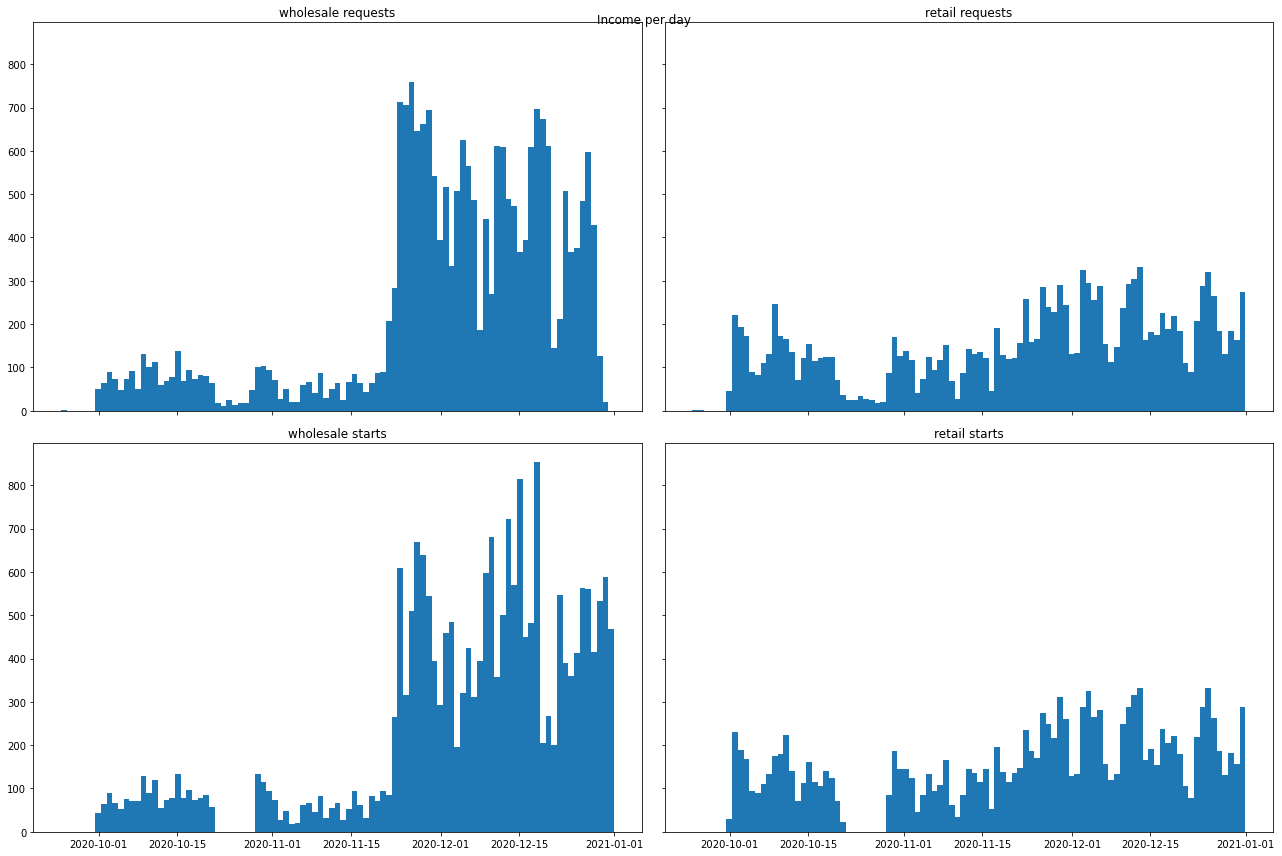

In [66]:
bins = pd.date_range(df['request_time'].min(), df['request_time'].max(), (df['request_time'].max() - df['request_time'].min()).days)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(18,12))
ax1.hist(df[df['team'] == 'wholesale']['request_time'], bins, label='retail')
ax1.set_title('wholesale requests')
ax2.hist(df[df['team'] == 'retail']['request_time'], bins, label='wholesale')
ax2.set_title('retail requests')

ax3.hist(df[df['team'] == 'wholesale']['start_time'], bins, label='retail')
ax3.set_title('wholesale starts')
ax4.hist(df[df['team'] == 'retail']['start_time'], bins, label='wholesale')
ax4.set_title('retail starts')
fig.tight_layout()
fig.suptitle('Income per day')
fig.show()

По графіку можемо помітити, що умовно після 2020-11-15 йде значний приріст кількості заявок на день, що потенційно може призвести до затримки відповіді на запити. Це виразніше помітно на групі wholesale. Порівнявши гістограми частот приходу запитів і кількості оброблених запитів за день <b>складається враження, що проблем із темпами обробки не мало б бути</b>. Вважаю доцільним перевірити успішність виконання очікувань менеджменту до цієї дати та після, та глянути  чи зріст кількісті заявок впливає на затримку відповіді на запититів. Також варто оцінити піковий час надходу запитів погодинно та по днях тижня.

In [59]:
df_check  = df[df['request_time'] < '2020-11-15']
df_check.groupby('team')['delay'].mean().apply(pd.Timedelta, unit='s')

team
retail      1 days 01:47:51.861564554
wholesale   1 days 21:14:55.296930764
Name: delay, dtype: timedelta64[ns]

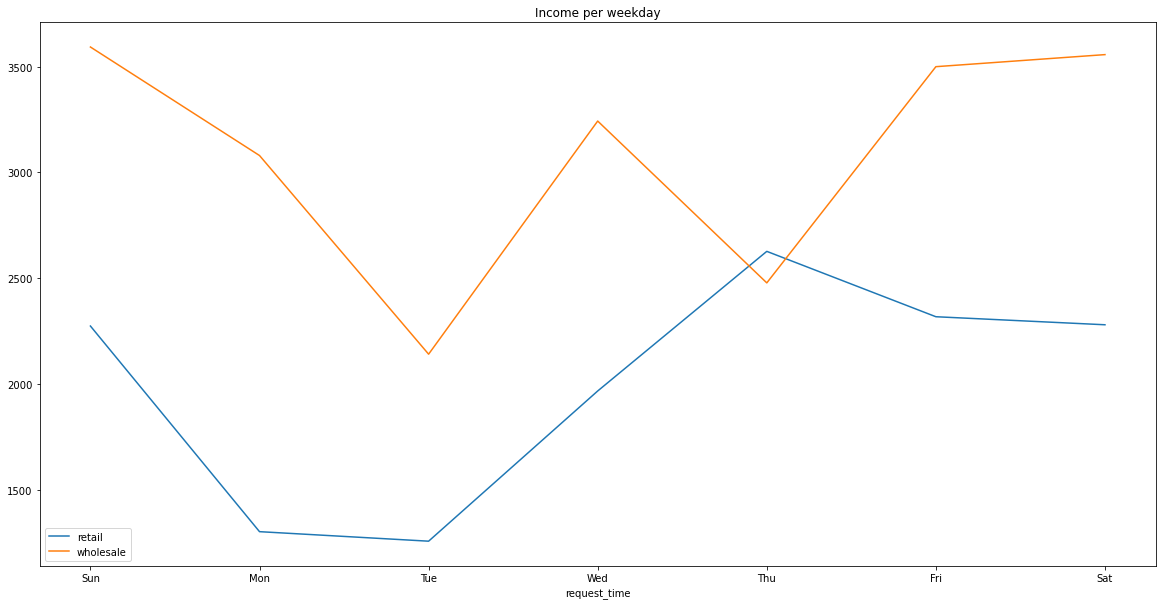

In [68]:
df_check_weekday = df.copy()
df_check_weekday['request_time'] = df['request_time'].dt.strftime('%a')
df_check_weekday[df_check_weekday['team'] == 'retail'].groupby('request_time').count().loc[['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], 'moderator'].plot(figsize=(20,10), label='retail')
df_check_weekday[df_check_weekday['team'] == 'wholesale'].groupby('request_time').count().loc[['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], 'moderator'].plot(figsize=(20,10), label='wholesale', title='Income per weekdayjj').legend()

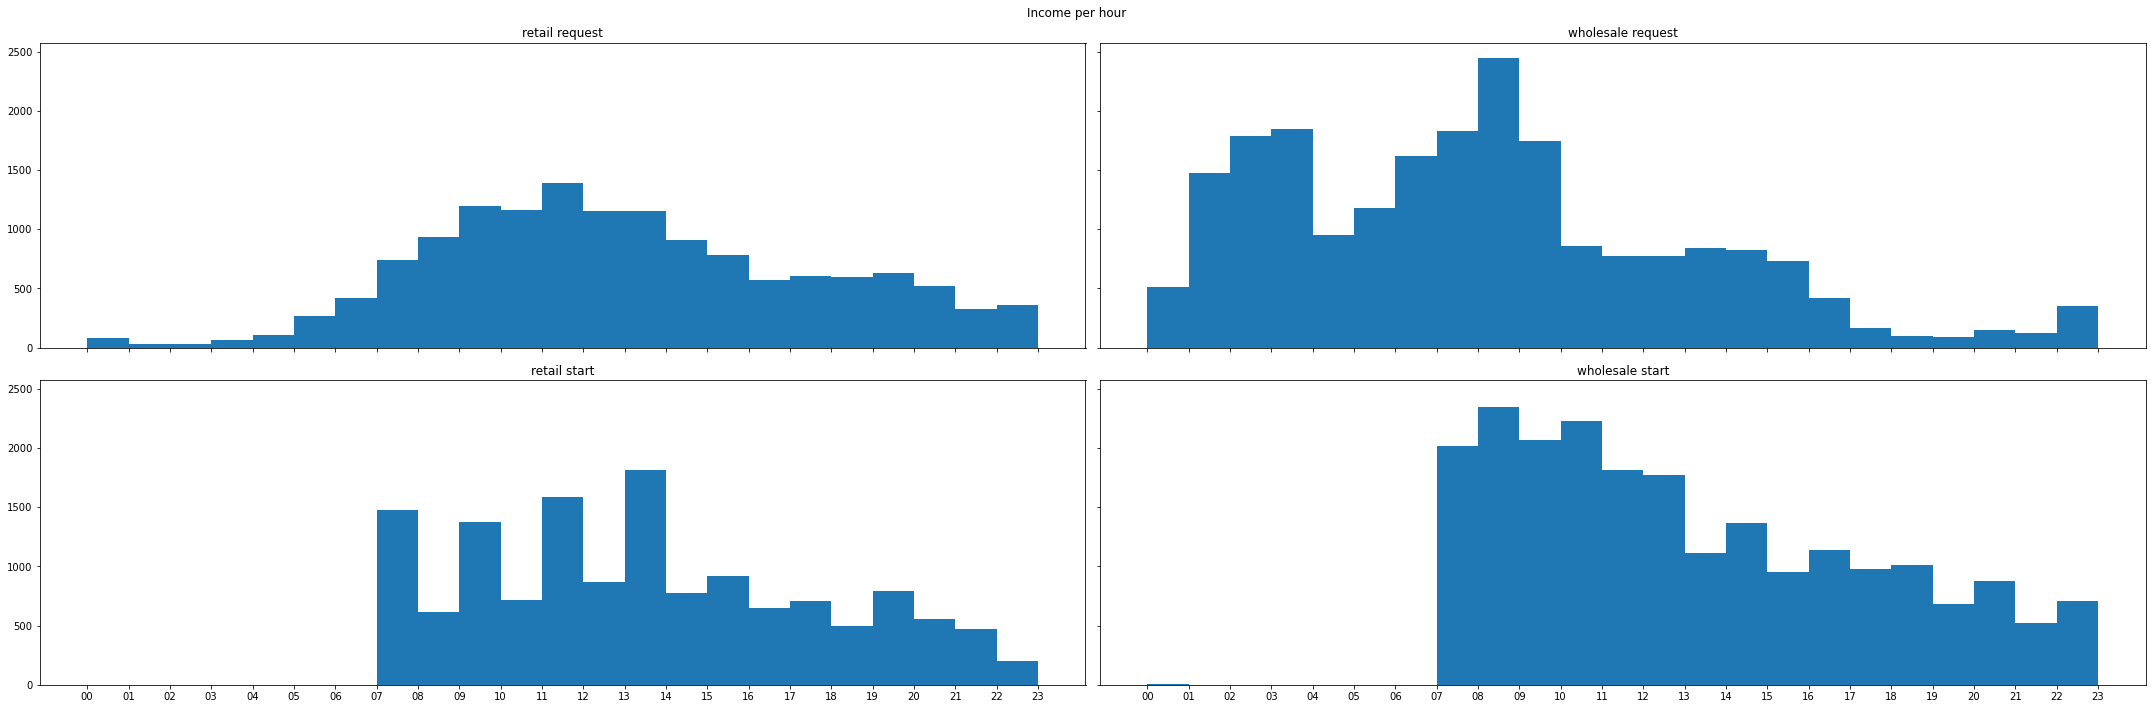

In [70]:
df_check_time = df.copy()
df_check_time['request_time'] = df['request_time'].dt.strftime('%H')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(30, 10))
ax1.hist(df_check_time[df_check_time['team'] == 'retail']['request_time'].sort_values(), np.arange(24))
ax1.set_title('retail request')
ax2.hist(df_check_time[df_check_time['team'] == 'wholesale']['request_time'].sort_values(), np.arange(24))
ax2.set_title('wholesale request')

df_check_time['start_time'] = df['start_time'].dt.strftime("%H")
ax3.hist(df_check_time[df_check_time['team'] == 'retail']['start_time'].sort_values(), np.arange(24))
ax3.set_title('retail start')
ax4.hist(df_check_time[df_check_time['team'] == 'wholesale']['start_time'].sort_values(), np.arange(24))
ax4.set_title('wholesale start')
fig.suptitle('Income per hour')
fig.tight_layout()
fig.show()

В результаті отримали, що очікування менеджменту не виконувалися й до значного прирості кількості заявок. Можемо помітити стандартну закономірність, що кількість запитів у неділю та на початку тижня спадає, а опісля поступово зростає. Також є очивидним, що група wholesale опримує значно більшу кількість заявак, за умови, що їш штат майже одної кількості (24 та 25 модераторів). Спостережування показують, що пік надходу запитів є різним у обох груп. Цікавим є те, що у групи wholesale приріст приходу заявок розпочинається о 1 годині ночі та починає спадати з 10 ранку, в той час, як ми можемо помітит, служба розпочинає роботу о 7 ранку, що вже викликає серйозну затримку й наштовхує на думку про <b>формування нічної</b> зміни для цього відділу. У сумі цих факторів, <b>можна припустити, що об'єднання відділів служби підтримки може підвищити якість обслуговуваня</b>. Наступнимим пропущеннями буде, що кількість модераторів в цілому недостатня для обробки всіх запитів або якість модераторів не відповідає очікуванням.

In [53]:
mod_check = df.drop(['processing_time', 'delay'], axis=1).copy()

mod_check['request_D'] = df['request_time'].dt.strftime('%D')
mean_req_before_DAY = mod_check[df['request_time'] < '2020-11-15'].groupby(['team', 'request_D']).count().iloc[:, 0].mean(level=0)
mean_req_before_DAY.name = 'mean_req_before_DAY_per_day'
mean_req_after_DAY = mod_check[df['request_time'] > '2020-11-15'].groupby(['team', 'request_D']).count().iloc[:, 0].mean(level=0)
mean_req_after_DAY.name = 'mean_req_after_DAY_per_day'
mean_req = mod_check.groupby(['team', 'request_D']).count().iloc[:, 0].mean(level=0)
mean_req.name = 'mean_req_per_day'

mod_check['start_D'] = df['start_time'].dt.strftime("%D")
mean_st_before_DAY = mod_check[df['request_time'] < '2020-11-15'].groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
mean_st_before_DAY.name = 'mean_st_before_DAY_per_day'
mean_st_after_DAY = mod_check[df['request_time'] > '2020-11-15'].groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
mean_st_after_DAY.name = 'mean_st_after_DAY_per_day'
mean_st = mod_check.groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
mean_st.name = 'mean_st_per_day'

mean_req_mod_all = mod_check.groupby(['team', 'moderator']).count().mean(level=0).iloc[:, 0]
mean_req_mod_all.name = 'mean_req_mod_all'
clear_mod = mod_check.groupby(['team', 'moderator']).count() 
good_mods = clear_mod[clear_mod['id_request'] > 200].count(level=0).iloc[:, 0]
good_mods.name = "n_good_mods"
good_mods_index = clear_mod[clear_mod['id_request'] > 200].index.get_level_values(1)
good_mod_check = mod_check[mod_check['moderator'].isin(good_mods_index)]

good_mean_st_before_DAY = good_mod_check[df['request_time'] < '2020-11-15'].groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
good_mean_st_before_DAY.name = 'good_mean_st_before_DAY_per_day'
good_mean_st_after_DAY = good_mod_check[df['request_time'] > '2020-11-15'].groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
good_mean_st_after_DAY.name = 'good_mean_st_after_DAY_per_day'
good_mean_st = good_mod_check.groupby(['team', 'start_D']).count().iloc[:, 0].mean(level=0)
good_mean_st.name = 'good_mean_st_per_day'

pd.concat([mean_req, mean_req_before_DAY, mean_req_after_DAY, mean_st, mean_st_before_DAY, mean_st_after_DAY, mean_req_mod_all, good_mods, good_mean_st, good_mean_st_before_DAY, good_mean_st_after_DAY,], axis=1)

,mean_req_per_day,mean_req_before_DAY_per_day,mean_req_after_DAY_per_day,mean_st_per_day,mean_st_before_DAY_per_day,mean_st_after_DAY_per_day,mean_req_mod_all,n_good_mods,good_mean_st_per_day,good_mean_st_before_DAY_per_day,good_mean_st_after_DAY_per_day
team,,,,,,,,,,,
retail,147.631579,98.270833,198.042553,165.000000,63.743243,198.042553,584.375,18,163.964706,62.554054,198.042553
wholesale,234.695652,60.913043,408.478261,254.023529,38.383562,399.787234,863.680,17,247.647059,31.369863,399.148936


Середня кількість запитів, що надходить в день (</b>mean_req_per_day</b>) для ratil 147, для wholesale 234, в той час як середня кількість запитів, яку обробляють модаретори за день (<b>mean_st_per_day</b>), рівна 165 для retail, 254 для wholesale, що може здатися задовільним, проте ці ж самі характеристики до умовного числа '2020-11-15' є 98 для retail та 60 для wholesale запитів в день (</b>mean_req_before_DAY_per_day</b>), а середня кількість запитів, що обробляється, (<b>mean_st_before_DAY_per_day</b>) скаладає 63 для retail та 38 для wholesale, чого явно було не достатньо і потенційно призвело до накопичення запитів. Опісля цієї дати кількість запитів, що надходить в день, (<b>mean_req_after_DAY_per_day</b>) не значущо відрізняється від кількості запитів, що оброблялася, (<b>mean_st_after_DAY_per_day</b>), а саме: 198 та 198 для retail, 408 та 399 для wholesale. Є момітний зріст продуктивності, та він все-таки не випереджає надходження, у нашому випадку нам потрібно в значній мірі обробляти більше запитів, аби вирівняти очікування менеджменту. В середньому модератори за весь даний час виконали (<b>mean_req_mod_all</b>) по 584 для retail та по 863 для wholesale запитів, то можемо відсіяти тих модераторів, що в значній мірі виконують менше роботи (нехай менше 200 запитів), і глянути,який внесок роблять саме ті модератори, що працюють достатньою. В нашоу випадку отримали 18 із 24 для retail та 17 із 25 для wholesale ефективних модераторів, як бачимо по аналогічним метрикам, але для відібраних ефективних модераторів (<b>good_mean_st_per_day</b>, <b>good_mean_st_before_DAY_per_day</b>, <b>good_mean_st_after_DAY_per_day</b>), саме вони і робити абсолютну більність роботи. У випадку якщо ж позбативитись в команді не ефективних модераторів, то щоб досягти бажаного результату (обробити всі наявні запити та не накопичувати згодом), потрібно добрати 1-5 ефективних модераторів для retial, та 3-7 ефективних модераторів для wholesale.

## Висновки та рекомендації
По результатам аналізу отриманих данних можу зробити такі виснвоки:
- динаміка кількості надходження і початку обробки запитів значно співавдають
- пікові погодинні нагрузки у відношенні до піку обробки запитів співпадають у групи retail та потребують корекції в групі wholesale
- різні пікові нагрузки груп в робочі дні дає змогу об'єднати команди
- кількисть середьоденних надходженнь запитів і кількість середньоденних обробки запитів майже співпадають (>), але для позитивного результату повинно переважати, тому можливо потрібне збільшення штату на кілька осіб
- середня кількість запитів, що обробляються, у значній мірі не перебільшують середню кількість запитів, що надходять
- вважаю наявну кількість данних не достатньою для повноцінного аналізу, так як відсутня інформація про: вид працевлаштування модераторів (part-time/full-time/...), робоча норма кількості оброблених запитів модераторів, зміну кадрів (кількість модераторів змінювалясь з часом), запити, що надійшли та не були оброблені до крайної дати в даних, кометарі про проблему від самих модераторів

<b>Пропоную</b> задля підвищення ефективності служби підтримки: сформувати нічну зміну служби підтримки; об'єднати команди на короткостроковий час (до трьох тижніх) та заміряти отриманий приріст ефективності, у разі задовільності результатом, залишити команду у такому складі. У разі недостатньості результату найняти додатково 1-5 нових модераторів для retail та 2-7 нових модераторів для wholesale в залежності від успішності отриманих результатів по об'єднанню команд.